In [6]:
%%time
import sklearn as sk
import pandas as pd
import os
import numpy as np
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import tree
from sklearn.tree import _tree
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import random
import math
import sympy 
from sympy import ifft
from sympy import fft
from numpy.fft import *
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Embedding, LSTM, Dropout, Activation
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import keras
from keras import utils
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from joblib import parallel_backend
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

early_stopping = EarlyStopping()
scaler = MinMaxScaler()
random.seed(42)

# Load datasets
padsiztrain = pd.read_csv('dayss.csv')  # train with pad
padlitrain = pd.read_csv('dayss.csv')  # train without pad
test = pd.read_csv('nextweekday2.csv')  # test with pad

# Set parameters
strategy= 0 #1 for Padding, 0 for Differential Privacy (FPA)
pad= 300 #100, 300, 350, 500, 700, 900, 42, 1500
vector=20 #Vector Size: 5, 10, 15, 20, 25, 30, 40, 50
k=5 #coefficients: 10, 20
epsilon=10 #epsilon: 0.05, 0.5, 5, 10"""
clip_top = 1500  
clip_bottom = 0

# Function to preprocess the data
def preprocess_data(data, clip_bottom, clip_top, drop_devices):
    data['Size'] = np.clip(data['Size'], clip_bottom, clip_top)
    data = data.loc[~data['device'].isin(drop_devices)]
    data['device'] = data['device'].replace([4,5,6,7,8,9,11,12,13,14,16,17,18,20],[3,4,5,6,7,8,9,10,11,12,13,14,15,16])
    data = data.sort_values(by=['device','TIME']).reset_index()
    return data

# Preprocess the data
drop_devices = [3,10,15,19]
padsiztrain = preprocess_data(padsiztrain, clip_bottom, clip_top, drop_devices)
padlitrain = preprocess_data(padlitrain, clip_bottom, clip_top, drop_devices)
test = preprocess_data(test, clip_bottom, clip_top, drop_devices)

def drop_dump_rows(data, vector):
    total = 0
    for device, count in data['device'].value_counts().sort_index().iteritems():
        dumpveri = count % vector
        dump = count - dumpveri
        data = data.drop(data.index[dump+total:count+total])
        total += dump
    return data

# drop the dump rows
padsiztrain = drop_dump_rows(padsiztrain, vector)
padlitrain = drop_dump_rows(padlitrain, vector)
test = drop_dump_rows(test, vector)
    
# Calculate the total sum of the 'Size' column of the test dataset
TestPadsizToplam = test['Size'].values.sum()

# Pad function
def pad_func(data, pad):
    if pad == 100:
        # apply padding strategy for pad value = 100
        data['Size']=data['Size'].apply(lambda length : 100 if length <= 100  #level 100
                                                    else (200 if 100<length <= 200 #level 100
                                                    else (300 if 200<length <= 300 #level 100
                                                    else ((length+random.randint(1, 1000-length)) if 300<length < 999 #All
                                                    else ((length+random.randint(1, 1400-length)) if 999<=length <= 1399 #All
                                                    else 1500 if 1400<=length  else 0    )))))  #All
    elif pad in [300, 350, 500, 700, 900]:
        # apply padding strategy for pad values = 300, 500, 700, 900
        data['Size'] = data['Size'].apply(lambda length : pad if length <= pad  #level 
                                                    else ((length+random.randint(1, 1000-length)) if pad<length < 999 
                                                    else ((length+random.randint(1, 1400-length)) if 999<=length <= 1399 
                                                    else 1500 if 1400<=length  else 0))) #All
    elif pad == 1000:
        # apply padding strategy for pad value = 'random'
         data['Size']=data['Size'].apply(lambda length : ((length+random.randint(1, 1500-length)) if length < 1500  #Random
                                                    else 1500 ))
    elif pad == 1500:
        # apply padding strategy for pad value = 'MTU'
        data['Size']=data['Size'].apply(lambda length : 1500   )  #MTU
    else:
        print("Please select the right padding name. (100,300,500,700,900, 1000(random) or 1500(MTU))")

# Apply padding
if strategy == 1:
    pad_func(padlitrain, pad)
    pad_func(test, pad)
    TestPadliToplam = test['Size'].values.sum()
    Overhead = (TestPadliToplam - TestPadsizToplam) / TestPadsizToplam * 100

# Function to prepare datasets
def prepare_data(data, vector):
    data['rowcount'] = np.arange(len(data))
    list = [None] * vector
    for i in range(vector):
        list[i] = data.loc[data['rowcount'] % vector == i].reset_index().rename({'Size': 'Size'+str(i+1)}, axis='columns')
    data = pd.concat([item for item in list], axis=1)
    data = data.drop([ 'TIME','index','rowcount'], axis=1)
    return data

# Prepare datasets
padlitrain = prepare_data(padlitrain, vector)
padsiztrain = prepare_data(padsiztrain, vector)
test = prepare_data(test, vector)

# Create copies of the dataframes dropping the 'device' column
padlitrain1 = padlitrain.drop(columns=['device','level_0'])
padlitrainFPA = padlitrain.drop(columns=['device'])
test1 = test.drop(columns=['device','level_0'])
testFPA = test.drop(columns=['device'])
padsiztrain1 = padsiztrain.drop(columns=['device'])

# Get 'device' columns from test and padsiztrain dataframes
testdevice = test.iloc[:, -1]
padsiztraindevice = padsiztrain.iloc[:, -1]

# Reset index and drop 'index' column from padlitrainFPA and testFPA dataframes
padlitrainFPA = padlitrainFPA.reset_index().drop(['index', 'level_0'], axis=1)
testFPA = testFPA.reset_index().drop(['index', 'level_0'], axis=1)
padsiztrain1 = padsiztrain1.reset_index().drop(['index', 'level_0'], axis=1)

# Get 'device' column from padlitrain dataframe
traindevice = padlitrain.iloc[:, -1]
        
# Strategy 0 section where FPA is performed
def FPAfunc(epsilon,k):
    # DFT
    for i in range (len(padlitrain)):
        l2sen=padlitrain1.iloc[i].values.max()-padlitrain1.iloc[i].values.min()
        padlitrainFPAold = np.fft.rfft(padlitrainFPA.iloc[i].transpose())
        n=len(padlitrainFPAold)
        padlitrainFPAnow=padlitrainFPAold[:k]
        
        #Laplace
        sensitivity = math.sqrt(k)*l2sen #arttırınca karışıklık artıyor
        noise_real = np.random.laplace(loc=0, scale=sensitivity/epsilon, size=np.shape(padlitrainFPAnow))
        noise_imag = np.random.laplace(loc=0, scale=sensitivity/epsilon, size=np.shape(padlitrainFPAnow))
        padlitrainFPAnow.real+=noise_real
        padlitrainFPAnow.imag+=noise_imag

        #pad
        padlen=n-k
        fftpad=np.pad(padlitrainFPAnow, pad_width=padlen, mode='constant', constant_values=0)[padlen:] 

        #IDFT
        padlitrainFPAnow = np.fft.irfft(fftpad) 
        padlitrainFPAnow = np.clip(padlitrainFPAnow,clip_bottom,clip_top)
        padlitrainFPA.iloc[i]=padlitrainFPAnow.transpose()
    
    # DFT
    for i in range (len(test)):
        l2sen=test1.iloc[i].values.max()-test1.iloc[i].values.min()
        testFPAold = np.fft.rfft(testFPA.iloc[i].transpose())
        n=len(testFPAold)
        testFPAnow=testFPAold[:k]
        
        #Laplace
        sensitivity = math.sqrt(k)*l2sen #arttırınca karışıklık artıyor
        noise_real = np.random.laplace(loc=0, scale=sensitivity/epsilon, size=np.shape(testFPAnow))
        noise_imag = np.random.laplace(loc=0, scale=sensitivity/epsilon, size=np.shape(testFPAnow))
        testFPAnow.real+=noise_real
        testFPAnow.imag+=noise_imag

        #pad
        padlen=n-k
        fftpad=np.pad(testFPAnow, pad_width=padlen, mode='constant', constant_values=0)[padlen:] 

        #IDFT
        testFPAnow = np.fft.irfft(fftpad)
        testFPAnow = np.clip(testFPAnow,clip_bottom,clip_top)
        testFPA.iloc[i]=testFPAnow.transpose()
    
    #################FPA Test##########################

    
    
##################################################
if strategy == 0:   
    FPAfunc(epsilon,k)
    TestPadliToplamFPA=testFPA.values.sum()
    Overhead=(TestPadliToplamFPA-TestPadsizToplam)/TestPadsizToplam*100
else:
    pass
pd.set_option('display.float_format', lambda x: '%.f' % x)
testFPA = pd.concat([testFPA, testdevice], axis=1)
padlitrainFPA = pd.concat([padlitrainFPA, traindevice], axis=1)
padsiztrain1= pd.concat([padsiztrain1, padsiztraindevice], axis=1) 


#XGBoost#
def run_xgb(train_X, train_y, test_X, test_y, observer_type):
    # Initialize the XGBoost model
    model = xgb.XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=50, random_state=101) 

    # Setup k-fold cross-validation
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=101)

    # Perform cross-validation
    with parallel_backend('threading', n_jobs=-1):
        scores = cross_val_score(model, train_X, train_y.values.ravel(), cv=kfold, scoring='accuracy')

    # Display accuracy for each fold
    for i, score in enumerate(scores, 1):
        print(f'Accuracy for fold {i}: {score*100:.2f}%')
        
    # Train the model with the full training set
    model.fit(train_X, train_y.values.ravel()) 

    # Make predictions on the train and test sets
    predicted_train_y = model.predict(train_X)
    predicted_test_y = model.predict(test_X)
    
    # Calculate and print mean training accuracy and variance
    mean_train_accuracy = np.mean(scores) * 100
    print(f'\nAverage training accuracy after 3-fold cross-validation: {mean_train_accuracy:.2f}%')
    print(f'Variance of test accuracy after 3-fold cross-validation: {np.var(scores) * 100:.2f}%')

    # Print observer type
    if strategy == 1:  # Padding
        print(f"\n------XGBoost Classifier (Vector Size: {vector}, Pad: {pad}, Observer: {observer_type}) ------")
    elif strategy == 0:  # FPA
        print(f"\n------XGBoost Classifier (Vector Size: {vector}, FPA parameters: k={k}, epsilon={epsilon:.2f}, {observer_type} Observer) ------")
    else:
        pass
    # Print the accuracy scores for the train and test sets
    train_accuracy = accuracy_score(train_y, predicted_train_y) * 100
    test_accuracy = accuracy_score(test_y, predicted_test_y) * 100
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Print classification report
    print(f"XGBoost Classification Report:\n{classification_report(test_y, predicted_test_y, zero_division=0)}")

    # Print byte overhead
    print(f"Byte Overhead: {Overhead}%")

    # Plot confusion matrix
    cm = confusion_matrix(test_y, predicted_test_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.gcf().set_size_inches(11, 11)
    plt.show()
    
#LSTM#
def run_lstm(train_X, train_y, test_X, test_y, observer_type):
    # Normalize the data
    scaler = MinMaxScaler()
    train_X = scaler.fit_transform(train_X)
    test_X = scaler.transform(test_X)

    # Convert labels to categorical
    encoder = LabelEncoder()
    train_y = encoder.fit_transform(train_y)
    test_y = encoder.transform(test_y)
    train_y = to_categorical(train_y)
    test_y = to_categorical(test_y)

    # Reshape the input data
    train_X = train_X.reshape(-1, 1, vector)
    test_X = test_X.reshape(-1, 1, vector)

    # Create the LSTM model
    model = Sequential()
    model.add(LSTM(256, activation='relu', input_shape=(1, vector)))
    model.add(Dropout(0.2))
    model.add(Dense(17, activation='softmax'))
    earlyStop = EarlyStopping(monitor="val_loss", verbose=2, mode='min', patience=10)

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    # Cross-validation during training
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    fold = 1
    cv_scores = []  # List to store cross-validation scores

    for train_index, val_index in kf.split(train_X):
        X_train, X_val = train_X[train_index], train_X[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]

        print(f"\nTraining for Fold {fold}")
        history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=2, callbacks=[earlyStop])

        # Evaluate on validation data for the current fold
        _, val_acc = model.evaluate(X_val, y_val, verbose=0)
        cv_scores.append(val_acc)  # Store validation accuracy for the fold
        fold += 1

    # Calculate and print mean cross-validation accuracy and variance
    mean_cv_accuracy = np.mean(cv_scores) * 100
    var_cv_accuracy = np.var(cv_scores) * 100
    print(f"\nAverage cross-validation accuracy after 3-fold cross-validation: {mean_cv_accuracy:.2f}%")
    print(f"Variance of cross-validation accuracy after 3-fold cross-validation: {var_cv_accuracy:.2f}%")

    # Evaluate on test data
    _, test_acc = model.evaluate(test_X, test_y, verbose=0)

    if strategy == 1:  # Padding
        print(f"\n------LSTM (Vector Size: {vector}, Pad: {pad}, Observer: {observer_type}) ------")
    elif strategy == 0:  # FPA
        print(f"\n------LSTM (Vector Size: {vector}, FPA parameters: k={k}, epsilon={epsilon:.2f}, Observer: {observer_type}) ------")
    else:
        pass

    # Print training accuracy, test accuracy, and classification report
    train_pred = model.predict(train_X)
    test_pred = model.predict(test_X)

    train_acc = accuracy_score(np.argmax(train_y, axis=1), np.argmax(train_pred, axis=1)) * 100
    test_acc = accuracy_score(np.argmax(test_y, axis=1), np.argmax(test_pred, axis=1)) * 100

    print(f"Training Accuracy: {train_acc:.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print("LSTM Classification Report:")
    print(classification_report(np.argmax(test_y, axis=1), np.argmax(test_pred, axis=1), zero_division=0))
    print("Byte Overhead: ", Overhead, "%")

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

Wall time: 46.6 s


Accuracy for fold 1: 60.91%
Accuracy for fold 2: 61.10%
Accuracy for fold 3: 60.95%

Average training accuracy after 3-fold cross-validation: 60.99%
Variance of test accuracy after 3-fold cross-validation: 0.00%

------XGBoost Classifier (Vector Size: 50, Pad: 300, Observer: Internal) ------
Training Accuracy: 64.65%
Test Accuracy: 62.77%
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       242
           1       0.69      0.23      0.35       456
           2       0.98      0.72      0.83       366
           3       0.96      0.99      0.98       778
           4       0.49      0.99      0.66      2288
           5       0.82      0.11      0.19       509
           6       0.88      0.30      0.45       399
           7       0.99      0.94      0.96       501
           8       0.00      0.00      0.00        21
           9       1.00      0.02      0.03       616
          10       0.00      0.00

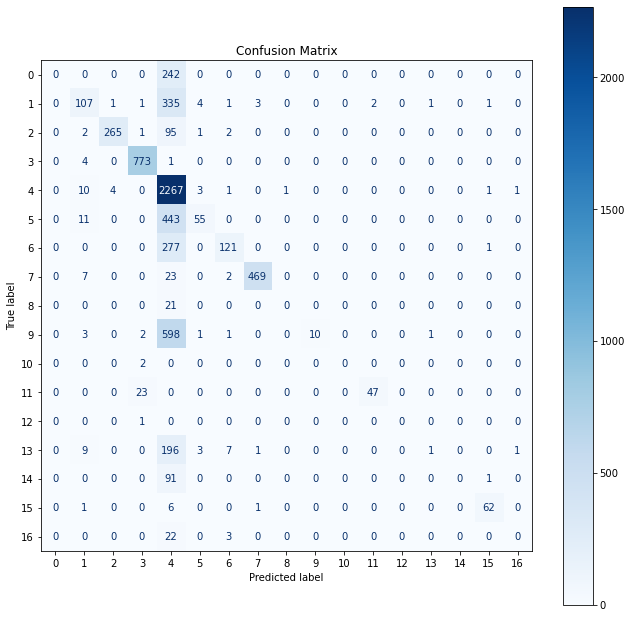

Wall time: 25.8 s


In [2]:
%%time
#XGBoost For Internal observer
train_X = padlitrainFPA.drop(columns=['device'])
train_y = padlitrainFPA[['device']]
test_X = testFPA.drop(columns=['device'])
test_y = testFPA[['device']]
run_xgb(train_X, train_y, test_X, test_y, 'Internal')

Accuracy for fold 1: 98.75%
Accuracy for fold 2: 98.74%
Accuracy for fold 3: 98.64%

Average training accuracy after 3-fold cross-validation: 98.71%
Variance of test accuracy after 3-fold cross-validation: 0.00%

------XGBoost Classifier (Vector Size: 50, Pad: 300, Observer: External) ------
Training Accuracy: 99.65%
Test Accuracy: 50.29%
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       242
           1       0.00      0.00      0.00       456
           2       1.00      0.66      0.80       366
           3       0.88      0.77      0.82       778
           4       0.42      1.00      0.59      2288
           5       0.00      0.00      0.00       509
           6       0.00      0.00      0.00       399
           7       0.93      0.43      0.59       501
           8       0.00      0.00      0.00        21
           9       0.00      0.00      0.00       616
          10       0.00      0.00

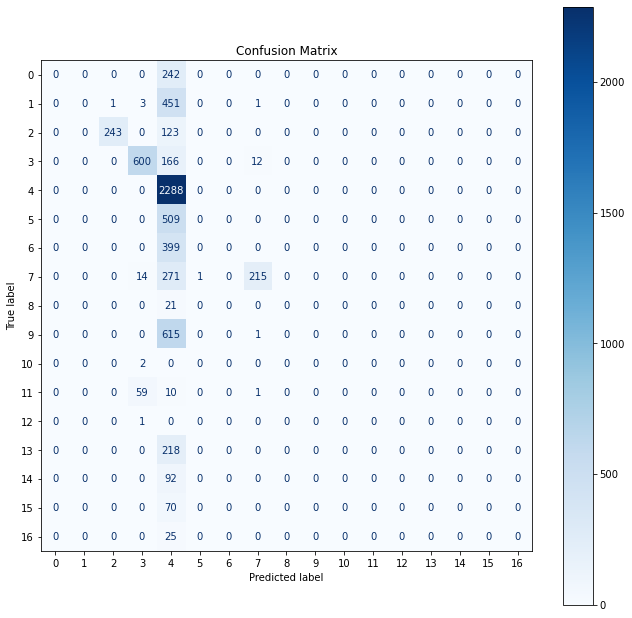

Wall time: 19.9 s


In [3]:
%%time
#XGBoost For External observer
train_X = padsiztrain1.drop(columns=['device'])
train_y = padsiztrain1[['device']]
test_X = testFPA.drop(columns=['device'])
test_y = testFPA[['device']]
run_xgb(train_X, train_y, test_X, test_y, 'External')

In [19]:
%%time
#LSTM For Internal observer
train_X = padlitrainFPA.drop(columns=['device'])
train_y = padlitrainFPA[['device']]
test_X = testFPA.drop(columns=['device'])
test_y = testFPA[['device']]

run_lstm(train_X, train_y, test_X, test_y, 'Internal')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 256)               314368    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 17)                4369      
                                                                 
Total params: 318,737
Trainable params: 318,737
Non-trainable params: 0
_________________________________________________________________
None


TypeError: split() missing 1 required positional argument: 'y'

In [20]:
%%time
#LSTM For External observer
train_X = padsiztrain1.drop(columns=['device'])
train_y = padsiztrain1[['device']]
test_X = testFPA.drop(columns=['device'])
test_y = testFPA[['device']]

run_lstm(train_X, train_y, test_X, test_y, 'External')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 256)               314368    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 17)                4369      
                                                                 
Total params: 318,737
Trainable params: 318,737
Non-trainable params: 0
_________________________________________________________________
None


TypeError: split() missing 1 required positional argument: 'y'